# Figure of station profile model evaluation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import netCDF4 as nc
import cmocean
import pandas as pd 
from matplotlib.patches import ConnectionPatch
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
import pickle
from datetime import date
from datetime import datetime
import xarray as xr
import glob
import gsw

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar
import seaborn as sns

###### Parameters:

In [3]:
# domain dimensions:
imin, imax = 1480, 2180
jmin, jmax = 160, 800

# results to plot:
folder_ref_2015      = f'/data/brogalla/run_storage/Mn-tuning-202107/ANHA12_ref-2015_euphotic/'
folder_ref_2009      = f'/data/brogalla/run_storage/Mn-tuning-202107/ANHA12_ref-2015_euphotic/'
folder_temp = f'/data/brogalla/ANHA12/salinity_ave/'

# colours:
land_color     = "#8b7765"
profile_colors = ['#e54141', '#33c7ff']

Model results

In [4]:
model_ref_2015 = nc.Dataset(f'{folder_ref_2015}ANHA12_EXH006_2015_monthly.nc')
lon_model    = np.array(model_ref_2015.variables['nav_lon'])
lat_model    = np.array(model_ref_2015.variables['nav_lat'])
depths_model = np.array(model_ref_2015.variables['deptht'])

In [5]:
sal = nc.Dataset(f'/data/brogalla/ANHA12/salinity_ave/ANHA12-EXH006_gridT_y2015m09.nc')
tem = nc.Dataset(f'/data/brogalla/ANHA12/salinity_ave/ANHA12-EXH006_gridT_y2015m09_temper.nc')
vosal_2015 = np.array(sal.variables['vosaline'])[0,:,imin:imax,jmin:jmax]
temp_2015  = np.array(tem.variables['votemper'])[0,:,imin:imax,jmin:jmax]
density_model = gsw.density.sigma0(vosal_2015, temp_2015)

Meshes

In [6]:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])
tmask    =  np.array(mesh.variables['tmask'])[0,:,imin:imax,jmin:jmax]
mlons    = np.array(mesh.variables['nav_lon'])
mlats    = np.array(mesh.variables['nav_lat'])
Z_masked = np.ma.masked_where((tmask > 0.1), tmask) 

Observations

In [7]:
# Concentration of dMn in 2015
# Manuel = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Fe&Mn_Integrated_Data_UBC-UVic_4-17-19_editedBR.csv')
Manuel = pd.read_csv('/ocean/brogalla/GEOTRACES/data/DMn_nmolL-1_BR-edited.csv')
Manuel_station_names = Manuel['Station'].astype('string')
Manuel_depths        = Manuel['Depth'].astype('float')
Manuel_dMn_nmolkg    = Manuel['nmol kg-1'].astype('float').values
Manuel_dMn_nmolL     = Manuel['nmol L-1'].astype('float').values
Manuel_salinity      = Manuel['Salinity'].astype('float').values
# Maneul_temperature = gsw.CT_from_rho(rho, SA, p)

In [8]:
GEOTRACES_CTD = pd.read_csv('/ocean/brogalla/GEOTRACES/data/combined.csv')
CTD_stations  = GEOTRACES_CTD['Station'].astype('string')
CTD_temp      = GEOTRACES_CTD['Temperature [ITS-90, deg C]'].astype('float')
CTD_sal       = GEOTRACES_CTD['Salinity, Practical [PSU]'].astype('float')
CTD_depth     = GEOTRACES_CTD['Depth [salt water, m], lat = 49.00'].astype('float')

# calculate density Manuel:
CTD_density = gsw.density.sigma0(CTD_sal, CTD_temp)

In [9]:
GEOTRACES = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
stn_names = GEOTRACES['Station names'].dropna().astype('str')
lons      = GEOTRACES['station lon'].astype('float').dropna().values
lats      = GEOTRACES['Station lat'].astype('float').dropna().values

In [10]:
CTD_temp_match = np.empty(Manuel_salinity.shape)
CTD_sal_match  = np.empty(Manuel_salinity.shape)
i = 0

for stn in stn_names:
    # Pair salinities from Manuel with temperatures from the CTD:
    temp_data  = CTD_temp[CTD_stations==stn].values
    sal_data   = CTD_sal[CTD_stations==stn].values
    depth_data = CTD_depth[CTD_stations==stn].values

    for depth in Manuel_depths[Manuel_station_names==stn]:
        try:
            ind_match = np.argmin(np.abs(depth_data-depth))
        
            CTD_temp_match[i] = temp_data[ind_match]   
            CTD_sal_match[i]  = sal_data[ind_match]    
        except:
            CTD_temp_match[i] = np.nan
            CTD_sal_match[i]  = np.nan
            
        i+=1
        
# calculate density Manuel:
GEOTRACES_density = gsw.density.sigma0(CTD_sal_match, CTD_temp_match)

##### Define functions

In [11]:
def match_data(name):
    # model: --------------------------------------------------------------------------------------------------
    lon_station = lons[stn_names==name]
    lat_station = lats[stn_names==name]
    model_stni, model_stnj = find_index_ANHA12_sub(lon_station, lat_station)
    model_stni = int(model_stni); model_stnj = int(model_stnj);

    temp_ref    = temp_2015[:, model_stni-1, model_stnj-1]
    density_ref = density_model[:, model_stni-1, model_stnj-1]
    sal_ref     = vosal_2015[:, model_stni-1, model_stnj-1]
    temp_ref_masked    = np.ma.masked_where((tmask[:,model_stni-1, model_stnj-1] < 0.1), temp_ref) # -1 because of subset of full model domain
    density_ref_masked = np.ma.masked_where((tmask[:,model_stni-1, model_stnj-1] < 0.1), density_ref) # -1 because of subset of full model domain
    sal_ref_masked     = np.ma.masked_where((tmask[:,model_stni-1, model_stnj-1] < 0.1), sal_ref) # -1 because of subset of full model domain
    
    temp_match = np.empty(Manuel_depths[Manuel_station_names==name].shape)
    sal_match  = np.empty(Manuel_depths[Manuel_station_names==name].shape)
    rho_match  = np.empty(Manuel_depths[Manuel_station_names==name].shape)
    
    for i, depth in enumerate(Manuel_depths[Manuel_station_names==name]):
        try:
            ind_match = np.argmin(np.abs(depths_model-depth))
        
            temp_match[i] = temp_ref_masked[ind_match]   
            sal_match[i]  = sal_ref_masked[ind_match]    
            rho_match[i]  = density_ref_masked[ind_match]    
        except:
            temp_match[i] = np.nan
            sal_match[i]  = np.nan
            rho_match[i]  = np.nan
    
    return temp_match, sal_match, rho_match

In [12]:
def find_index_ANHA12_sub(transect_lons, transect_lats, ANHA12sub_lon=lon_model, ANHA12sub_lat=lat_model):
    # input:   ANHA12sub_lon, ANHA12sub_lat --- 570x600 coordinates
    #          transect_lons, transect_lats --- list of lat and lon values to include in the transect
    # output:  i, j                         --- lists of coordinates associated with these points
    
    transect_i = np.array([])
    transect_j = np.array([])
    
    if isinstance(transect_lons,float):
        i, j = ar.find_closest_model_point(transect_lons, transect_lats, ANHA12sub_lon, ANHA12sub_lat)
        transect_i = int(i)
        transect_j = int(j)
    else:
        for k in range(0,len(transect_lons)):
            i, j = ar.find_closest_model_point(transect_lons[k], transect_lats[k], ANHA12sub_lon, ANHA12sub_lat)
            transect_i = np.append(transect_i, int(i))
            transect_j = np.append(transect_j, int(j))
    
    return transect_i, transect_j

In [13]:
def station_profile_temp(ax, name, patch=False, full=True):
    
    ax.invert_yaxis()
    ax.tick_params(labelsize=6, pad=0)
    ax.set_xlim([-2, 4])
    ax.xaxis.tick_top()    
    ax.xaxis.set_label_position('top') 
    ax.set_xticks([-2,0,2,4])
    
    # observations: -------------------------------------------------------------------------------------------
    depth_obs = CTD_depth[CTD_stations==name].values
    temp_obs  = CTD_temp[CTD_stations==name].values

    ax.plot(temp_obs, depth_obs, '-', zorder=4, markeredgewidth=0.5, markeredgecolor='k', color=profile_colors[0])

    plot_depth_lowerrange = depth_obs[-1] # deepest observation    
    plot_depth_upperrange = depth_obs[0]  # shallowest observation
    
    # model: --------------------------------------------------------------------------------------------------
    lon_station = lons[stn_names==name]
    lat_station = lats[stn_names==name]

    model_stni, model_stnj = find_index_ANHA12_sub(lon_station, lat_station)
    model_stni = int(model_stni); model_stnj = int(model_stnj);

    temp_ref = temp_2015[:, model_stni-1, model_stnj-1]

    temp_ref_masked = np.ma.masked_where((tmask[:,model_stni-1, model_stnj-1] < 0.1), temp_ref) # -1 because of subset of full model domain
    
    ################### full water column #############################
    if full:
        ax.plot(temp_ref_masked, depths_model, '-', zorder=1, linewidth=1.8, color=profile_colors[1])
        
        ax.set_ylim([plot_depth_lowerrange*1.2, 0-(plot_depth_lowerrange*0.04)])
        ax.text(0, plot_depth_lowerrange*0.99, name, fontsize=6)

        if patch:
            # Background patches behind profiles: ----------------------------------------------------------------------
            #top patch:
            x0_top     = -5;      y0_top     = -(plot_depth_lowerrange*0.3);
            width_top  = 11;      height_top = (plot_depth_lowerrange*0.3);
            box_top    = mpl.patches.Rectangle((x0_top,y0_top), width_top, height_top, facecolor='w', clip_on=False, \
                                              alpha=0.9, zorder=1)
            ax.add_patch(box_top)

            #left side patch:
            x0_side     = -5;     y0_side     = 0;
            width_side  = 11;     height_side = plot_depth_lowerrange*1.24
            box_side    = mpl.patches.Rectangle((x0_side,y0_side), width_side, height_side, \
                                                facecolor='w', clip_on=False, alpha=0.9, zorder=1)
            ax.add_patch(box_side)
       
    ################### zoom in on the surface #############################
    else:
        ax.plot(temp_ref_masked, depths_model, '-', zorder=1, linewidth=1.8, color=profile_colors[1])

        ax.set_ylim([100, 0])
        ax.text(0, 96, name, fontsize=6)

        if patch:
        # Background patches behind profiles: ----------------------------------------------------------------------
            #top patch:
            x0_top     = -5;     y0_top     = -30;
            width_top  = 11;     height_top = 30;
            box_top    = mpl.patches.Rectangle((x0_top,y0_top), width_top, height_top, facecolor='w', clip_on=False, \
                                               alpha=0.9, zorder=1)
            ax.add_patch(box_top)
            
            #left side patch:
            x0_side     = -5;     y0_side     = 0;
            width_side  = 11;     height_side = 105;
            box_side    = mpl.patches.Rectangle((x0_side,y0_side), width_side, height_side, \
                                                facecolor='w', clip_on=False, alpha=0.9, zorder=1)
            ax.add_patch(box_side)
    return

In [14]:
def station_profile_sal(ax, name, patch=False, full=True):
    
    ax.invert_yaxis()
    ax.tick_params(labelsize=6, pad=0)
    ax.set_xlim([26, 36])
    ax.xaxis.tick_top()    
    ax.xaxis.set_label_position('top') 
    ax.set_xticks([26,30,34])
    
    # observations: -------------------------------------------------------------------------------------------
    depth_obs = CTD_depth[CTD_stations==name].values
    sal_obs   = CTD_sal[CTD_stations==name].values

    ax.plot(sal_obs, depth_obs, '-', zorder=4, markeredgewidth=0.5, markeredgecolor='k', color=profile_colors[0])

    plot_depth_lowerrange = depth_obs[-1] # deepest observation    
    plot_depth_upperrange = depth_obs[0]  # shallowest observation
    
    # model: --------------------------------------------------------------------------------------------------
    lon_station = lons[stn_names==name]
    lat_station = lats[stn_names==name]

    model_stni, model_stnj = find_index_ANHA12_sub(lon_station, lat_station)
    model_stni = int(model_stni); model_stnj = int(model_stnj);

    sal_ref = vosal_2015[:, model_stni-1, model_stnj-1]

    sal_ref_masked = np.ma.masked_where((tmask[:,model_stni-1, model_stnj-1] < 0.1), sal_ref) # -1 because of subset of full model domain
    
    ################### full water column #############################
    if full:
        ax.plot(sal_ref_masked, depths_model, '-', zorder=1, linewidth=1.8, color=profile_colors[1])
        
        ax.set_ylim([plot_depth_lowerrange*1.2, 0-(plot_depth_lowerrange*0.04)])
        ax.text(30, plot_depth_lowerrange*0.99, name, fontsize=6)

        if patch:
            # Background patches behind profiles: ----------------------------------------------------------------------
            #top patch:
            x0_top     = 23;      y0_top     = -(plot_depth_lowerrange*0.3);
            width_top  = 12;      height_top = (plot_depth_lowerrange*0.3);
            box_top    = mpl.patches.Rectangle((x0_top,y0_top), width_top, height_top, facecolor='w', clip_on=False, \
                                              alpha=0.9, zorder=1)
            ax.add_patch(box_top)

            #left side patch:
            x0_side     = 23;     y0_side     = 0;
            width_side  = 12;     height_side = plot_depth_lowerrange*1.24
            box_side    = mpl.patches.Rectangle((x0_side,y0_side), width_side, height_side, \
                                                facecolor='w', clip_on=False, alpha=0.9, zorder=1)
            ax.add_patch(box_side)
       
    ################### zoom in on the surface #############################
    else:
        ax.plot(sal_ref_masked, depths_model, '-', zorder=1, linewidth=1.8, color=profile_colors[1])

        ax.set_ylim([100, 0])
        ax.text(30, 96, name, fontsize=6)

        if patch:
        # Background patches behind profiles: ----------------------------------------------------------------------
            #top patch:
            x0_top     = 23;     y0_top     = -30;
            width_top  = 12;     height_top = 30;
            box_top    = mpl.patches.Rectangle((x0_top,y0_top), width_top, height_top, facecolor='w', clip_on=False, \
                                               alpha=0.9, zorder=1)
            ax.add_patch(box_top)
            
            #left side patch:
            x0_side     = 23;     y0_side     = 0;
            width_side  = 12;     height_side = 105;
            box_side    = mpl.patches.Rectangle((x0_side,y0_side), width_side, height_side, \
                                                facecolor='w', clip_on=False, alpha=0.9, zorder=1)
            ax.add_patch(box_side)
    return

In [15]:
def station_profile_density(ax, name, patch=False, full=True):
    
    ax.invert_yaxis()
    ax.tick_params(labelsize=6, pad=0)
    ax.set_xlim([20, 28])
    ax.xaxis.tick_top()    
    ax.xaxis.set_label_position('top') 
    ax.set_xticks([20,24,28])
    
    # observations: -------------------------------------------------------------------------------------------
    depth_obs   = CTD_depth[CTD_stations==name].values
    density_obs = CTD_density[CTD_stations==name].values

    ax.plot(density_obs, depth_obs, '-', zorder=4, markeredgewidth=0.5, markeredgecolor='k', color=profile_colors[0])

    plot_depth_lowerrange = depth_obs[-1] # deepest observation    
    plot_depth_upperrange = depth_obs[0]  # shallowest observation
    
    # model: --------------------------------------------------------------------------------------------------
    lon_station = lons[stn_names==name]
    lat_station = lats[stn_names==name]

    model_stni, model_stnj = find_index_ANHA12_sub(lon_station, lat_station)
    model_stni = int(model_stni); model_stnj = int(model_stnj);

    density_ref = density_model[:, model_stni-1, model_stnj-1]

    density_ref_masked = np.ma.masked_where((tmask[:,model_stni-1, model_stnj-1] < 0.1), density_ref) # -1 because of subset of full model domain
    
    ################### full water column #############################
    if full:
        ax.plot(density_ref_masked, depths_model, '-', zorder=1, linewidth=1.8, color=profile_colors[1])
        
        ax.set_ylim([plot_depth_lowerrange*1.2, 0-(plot_depth_lowerrange*0.04)])
        ax.text(23, plot_depth_lowerrange*0.99, name, fontsize=6)

        if patch:
            # Background patches behind profiles: ----------------------------------------------------------------------
            #top patch:
            x0_top     = 16;      y0_top     = -(plot_depth_lowerrange*0.3);
            width_top  = 12;      height_top = (plot_depth_lowerrange*0.3);
            box_top    = mpl.patches.Rectangle((x0_top,y0_top), width_top, height_top, facecolor='w', clip_on=False, \
                                              alpha=0.9, zorder=1)
            ax.add_patch(box_top)

            #left side patch:
            x0_side     = 16;     y0_side     = 0;
            width_side  = 12;     height_side = plot_depth_lowerrange*1.24
            box_side    = mpl.patches.Rectangle((x0_side,y0_side), width_side, height_side, \
                                                facecolor='w', clip_on=False, alpha=0.9, zorder=1)
            ax.add_patch(box_side)
       
    ################### zoom in on the surface #############################
    else:
        ax.plot(density_ref_masked, depths_model, '-', zorder=1, linewidth=1.8, color=profile_colors[1])

        ax.set_ylim([100, 0])
        ax.text(23, 96, name, fontsize=6)

        if patch:
        # Background patches behind profiles: ----------------------------------------------------------------------
            #top patch:
            x0_top     = 16;     y0_top     = -30;
            width_top  = 12;     height_top = 30;
            box_top    = mpl.patches.Rectangle((x0_top,y0_top), width_top, height_top, facecolor='w', clip_on=False, \
                                               alpha=0.9, zorder=1)
            ax.add_patch(box_top)
            
            #left side patch:
            x0_side     = 16;     y0_side     = 0;
            width_side  = 12;     height_side = 105;
            box_side    = mpl.patches.Rectangle((x0_side,y0_side), width_side, height_side, \
                                                facecolor='w', clip_on=False, alpha=0.9, zorder=1)
            ax.add_patch(box_side)
    return

In [36]:
def station_profile_anomaly(ax, name, patch=False, full=True):
    
    ax.invert_yaxis()
    ax.tick_params(labelsize=6, pad=0)
    ax.set_xlim([-5,5])
    ax.xaxis.tick_top()    
    ax.xaxis.set_label_position('top') 
    ax.set_xticks([-4,-2,0,2,4])
    
    # observations: -------------------------------------------------------------------------------------------
    depth_obs    = Manuel_depths[Manuel_station_names==name].values
    density_obs  = GEOTRACES_density[np.array(Manuel_station_names==name, dtype=bool)]
    salinity_obs = CTD_sal_match[np.array(Manuel_station_names==name, dtype=bool)]
    temp_obs     = CTD_temp_match[np.array(Manuel_station_names==name, dtype=bool)]

    plot_depth_lowerrange = depth_obs[-1] # deepest observation    
    plot_depth_upperrange = depth_obs[0]  # shallowest observation
    
    # model: --------------------------------------------------------------------------------------------------
    temp_match, sal_match, rho_match = match_data(name)
    
    ################### full water column #############################
    if full:
        ax.plot(temp_match-temp_obs, depth_obs, '-', zorder=1, linewidth=1.8, color=profile_colors[1])
        ax.plot(sal_match-salinity_obs, depth_obs, '-', zorder=1, linewidth=1.8, color=profile_colors[0])
        ax.plot(rho_match-density_obs, depth_obs, '-', zorder=1, linewidth=1.8, color='gray')
        ax.plot([0,0],[4000,0], '-', zorder=1, linewidth=1.0, color='k')
        
        ax.set_ylim([plot_depth_lowerrange*1.2, 0-(plot_depth_lowerrange*0.04)])
        ax.text(1, plot_depth_lowerrange*0.99, name, fontsize=6)

        if patch:
            # Background patches behind profiles: ----------------------------------------------------------------------
            #top patch:
            x0_top     = -10;      y0_top     = -(plot_depth_lowerrange*0.3);
            width_top  = 14;      height_top = (plot_depth_lowerrange*0.3);
            box_top    = mpl.patches.Rectangle((x0_top,y0_top), width_top, height_top, facecolor='w', clip_on=False, \
                                              alpha=0.9, zorder=1)
            ax.add_patch(box_top)

            #left side patch:
            x0_side     = -10;     y0_side     = 0;
            width_side  = 14;     height_side = plot_depth_lowerrange*1.24
            box_side    = mpl.patches.Rectangle((x0_side,y0_side), width_side, height_side, \
                                                facecolor='w', clip_on=False, alpha=0.9, zorder=1)
            ax.add_patch(box_side)
       
    ################### zoom in on the surface #############################
    else:
        ax.plot(temp_match-temp_obs, depth_obs, '-', zorder=1, linewidth=1.6, color=profile_colors[1], \
                markersize=5, marker='.', markeredgecolor='k')
        ax.plot(sal_match-salinity_obs, depth_obs, '-', zorder=1, linewidth=1.8, color=profile_colors[0], \
                markersize=6, marker='.', markeredgecolor='k')
        ax.plot(rho_match-density_obs, depth_obs, '-', zorder=1, linewidth=1.6, color='gray', \
                markersize=5, marker='.', markeredgecolor='k')
        ax.plot([0,0],[4000,0], '-', zorder=1, linewidth=1.0, color='k')
    
        ax.set_ylim([100, 0])
        ax.text(1, 96, name, fontsize=6)

        if patch:
        # Background patches behind profiles: ----------------------------------------------------------------------
            #top patch:
            x0_top     = -10;     y0_top     = -5;
            width_top  = 14;     height_top = 30;
            box_top    = mpl.patches.Rectangle((x0_top,y0_top), width_top, height_top, facecolor='w', clip_on=False, \
                                               alpha=0.9, zorder=1)
            ax.add_patch(box_top)
            
            #left side patch:
            x0_side     = -10;     y0_side     = 0;
            width_side  = 14;     height_side = 105;
            box_side    = mpl.patches.Rectangle((x0_side,y0_side), width_side, height_side, \
                                                facecolor='w', clip_on=False, alpha=0.9, zorder=1)
            ax.add_patch(box_side)
    return

In [37]:
def full_figure(ln_full=True, savefig=False, title='', profile_type='sal'):
    
    fig, ax, proj1, proj2 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-eval-combined.pickle','rb'))
    #--------------------------------------------------------------------------------------------------------------------------
    ### Left plot ###
    x_GEOTRACES, y_GEOTRACES = proj1(lons, lats)
    ax[0].scatter(x_GEOTRACES, y_GEOTRACES, marker='*', s=60, zorder=7, edgecolor='k', linewidth=0.5, color='w', label='2015 GEOTRACES')
    ax[0].legend(loc=(-0.03, 1.02), fontsize=7, frameon=False)

    #--------------------------------------------------------------------------------------------------------------------------
    ### Right plot ###
    x_GEOTRACES, y_GEOTRACES = proj2(lons, lats)
    ax[1].scatter(x_GEOTRACES, y_GEOTRACES, marker='*', s=60, zorder=7, edgecolor='k', linewidth=0.5, color='w')

    # profile plots:
    ax1 = plt.axes([0.84, 0.65, 0.05, 0.17])
    ax2 = plt.axes([0.84, 0.38, 0.05, 0.17]) #CAA1
    ax3 = plt.axes([0.84, 0.14, 0.05, 0.17]) 
    ax4 = plt.axes([0.71, 0.14, 0.05, 0.17])
    ax5 = plt.axes([0.765, 0.65, 0.05, 0.17])
    ax6 = plt.axes([0.62, 0.14, 0.05, 0.17]) 
    ax7 = plt.axes([0.54, 0.14, 0.05, 0.17])
    ax8 = plt.axes([0.46, 0.14, 0.05, 0.17])
    ax9 = plt.axes([0.69, 0.65, 0.05, 0.17])
    ax10 = plt.axes([0.61, 0.65, 0.05, 0.17]) #CB1
    ax11 = plt.axes([0.46, 0.36, 0.05, 0.17])
    ax12 = plt.axes([0.54, 0.76, 0.05, 0.17])
    ax13 = plt.axes([0.46, 0.76, 0.05, 0.17])

    axes_list=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13]

    if profile_type == 'sal':
        fig1 = station_profile_sal(ax1, 'CAA1', patch=True, full=ln_full)
        fig2 = station_profile_sal(ax2, 'CAA2', patch=True, full=ln_full)
        fig3 = station_profile_sal(ax3, 'CAA3', patch=True, full=ln_full)
        fig4 = station_profile_sal(ax4, 'CAA4', patch=True, full=ln_full)
        fig5 = station_profile_sal(ax5, 'CAA5', patch=True, full=ln_full)
        fig6 = station_profile_sal(ax6, 'CAA6', patch=True, full=ln_full)
        fig7 = station_profile_sal(ax7, 'CAA7', patch=True, full=ln_full)
        fig8 = station_profile_sal(ax8, 'CAA8', patch=True, full=ln_full)
        fig9 = station_profile_sal(ax9, 'CAA9', full=ln_full)
        fig10 = station_profile_sal(ax10, 'CB1', full=ln_full)
        fig11 = station_profile_sal(ax11, 'CB2', patch=True, full=ln_full)
        fig12 = station_profile_sal(ax12, 'CB3', full=ln_full)
        fig13 = station_profile_sal(ax13, 'CB4', full=ln_full)
    elif profile_type =='temp':
        fig1 = station_profile_temp(ax1, 'CAA1', patch=True, full=ln_full)
        fig2 = station_profile_temp(ax2, 'CAA2', patch=True, full=ln_full)
        fig3 = station_profile_temp(ax3, 'CAA3', patch=True, full=ln_full)
        fig4 = station_profile_temp(ax4, 'CAA4', patch=True, full=ln_full)
        fig5 = station_profile_temp(ax5, 'CAA5', patch=True, full=ln_full)
        fig6 = station_profile_temp(ax6, 'CAA6', patch=True, full=ln_full)
        fig7 = station_profile_temp(ax7, 'CAA7', patch=True, full=ln_full)
        fig8 = station_profile_temp(ax8, 'CAA8', patch=True, full=ln_full)
        fig9 = station_profile_temp(ax9, 'CAA9', full=ln_full)
        fig10 = station_profile_temp(ax10, 'CB1', full=ln_full)
        fig11 = station_profile_temp(ax11, 'CB2', patch=True, full=ln_full)
        fig12 = station_profile_temp(ax12, 'CB3', full=ln_full)
        fig13 = station_profile_temp(ax13, 'CB4', full=ln_full)
    elif profile_type =='density':
        fig1 = station_profile_density(ax1, 'CAA1', patch=True, full=ln_full)
        fig2 = station_profile_density(ax2, 'CAA2', patch=True, full=ln_full)
        fig3 = station_profile_density(ax3, 'CAA3', patch=True, full=ln_full)
        fig4 = station_profile_density(ax4, 'CAA4', patch=True, full=ln_full)
        fig5 = station_profile_density(ax5, 'CAA5', patch=True, full=ln_full)
        fig6 = station_profile_density(ax6, 'CAA6', patch=True, full=ln_full)
        fig7 = station_profile_density(ax7, 'CAA7', patch=True, full=ln_full)
        fig8 = station_profile_density(ax8, 'CAA8', patch=True, full=ln_full)
        fig9 = station_profile_density(ax9, 'CAA9', full=ln_full)
        fig10 = station_profile_density(ax10, 'CB1', full=ln_full)
        fig11 = station_profile_density(ax11, 'CB2', patch=True, full=ln_full)
        fig12 = station_profile_density(ax12, 'CB3', full=ln_full)
        fig13 = station_profile_density(ax13, 'CB4', full=ln_full)
    else:
        print('Not a valid type of profile. Should be either sal or temp.')

    # create lines connecting the profiles:
    coordsA = "data"
    coordsB = "data"
    for i in range(len(stn_names[5:18])):
        xy1 = (x_GEOTRACES[i+5], y_GEOTRACES[i+5])
        if profile_type=='sal':
            xy2 = (28, 50)
        elif profile_type=='temp':
            xy2 = (2, 50)
        elif profile_type=='density':
            xy2 = (25, 50)
        axB = axes_list[i]
        con = ConnectionPatch(xyA=xy1, xyB=xy2, axesA=ax[1], axesB=axB, \
                              coordsA=coordsA, coordsB=coordsB, linestyle="dotted", linewidth=1.0, zorder=2)
        ax[1].add_artist(con)

    # legend
    ax[1].plot(0,0,'-', c=profile_colors[0], linewidth=2.5, label='Observed')
    ax[1].plot(0,0,'-', c=profile_colors[1], linewidth=2.5, label='Modelled')
    ax[1].legend(loc=(-0.33, 1.01), fontsize=7, frameon=False, handlelength=0.7)

    #-----------------------------------------------------------------------------------------------------------------------------------
    ### Full figure ###
    fig.text(0.1, 0.95, 'a)', fontsize=9);
    fig.text(0.4, 0.95, 'b)', fontsize=9);
    
    fig.text(0.3, 1.00, title, fontsize=9);

    if savefig:
        fig.savefig('/ocean/brogalla/GEOTRACES/figures/eval-zoom-20210713.png', bbox_inches='tight')
        
    return

In [38]:
def full_figure_density(savefig=False, title=''):
    
    fig, ax, proj1, proj2 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-eval-combined.pickle','rb'))
    #--------------------------------------------------------------------------------------------------------------------------
    ### Left plot ###

    # profile plots:
    ax1 = plt.axes([0.155, 0.15, 0.05, 0.17]) #L1
    ax2 = plt.axes([0.155, 0.39, 0.05, 0.17]) #L1.1 
    ax3 = plt.axes([0.155, 0.66, 0.05, 0.17]) #L1.5 
    ax4 = plt.axes([0.3, 0.66, 0.05, 0.17])  #L2
    ax5 = plt.axes([0.3, 0.39, 0.05, 0.17]) #L3
    ax6 = plt.axes([0.3, 0.15, 0.05, 0.17])  #S4
    axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

    x_GEOTRACES, y_GEOTRACES = proj1(lons, lats)
    ax[0].scatter(x_GEOTRACES, y_GEOTRACES, marker='*', s=60, zorder=7, edgecolor='k', linewidth=0.5, color='w', label='2015 GEOTRACES')
    ax[0].legend(loc=(-0.03, 1.02), fontsize=7, frameon=False)

    #--------------------------------------------------------------------------------------------------------------------------
    ### Right plot ###
    x_GEOTRACES, y_GEOTRACES = proj2(lons, lats)
    ax[1].scatter(x_GEOTRACES, y_GEOTRACES, marker='*', s=60, zorder=7, edgecolor='k', linewidth=0.5, color='w')

    # profile plots:
    ax1 = plt.axes([0.84, 0.65, 0.05, 0.17])
    ax2 = plt.axes([0.84, 0.38, 0.05, 0.17]) #CAA1
    ax3 = plt.axes([0.84, 0.14, 0.05, 0.17]) 
    ax4 = plt.axes([0.71, 0.14, 0.05, 0.17])
    ax5 = plt.axes([0.765, 0.65, 0.05, 0.17])
    ax6 = plt.axes([0.62, 0.14, 0.05, 0.17]) 
    ax7 = plt.axes([0.54, 0.14, 0.05, 0.17])
    ax8 = plt.axes([0.46, 0.14, 0.05, 0.17])
    ax9 = plt.axes([0.69, 0.65, 0.05, 0.17])
    ax10 = plt.axes([0.61, 0.65, 0.05, 0.17]) #CB1
    ax11 = plt.axes([0.46, 0.36, 0.05, 0.17])
    ax12 = plt.axes([0.54, 0.76, 0.05, 0.17])
    ax13 = plt.axes([0.46, 0.76, 0.05, 0.17])

    axes_list=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13]

    fig1 = station_profile_density(ax1, 'CAA1', patch=True)
    fig2 = station_profile_density(ax2, 'CAA2', patch=True)
    fig3 = station_profile_density(ax3, 'CAA3', patch=True)
    fig4 = station_profile_density(ax4, 'CAA4', patch=True)
    fig5 = station_profile_density(ax5, 'CAA5', patch=True)
    fig6 = station_profile_density(ax6, 'CAA6', patch=True)
    fig7 = station_profile_density(ax7, 'CAA7', patch=True)
    fig8 = station_profile_density(ax8, 'CAA8', patch=True)
    fig9 = station_profile_density(ax9, 'CAA9')
    fig10 = station_profile_density(ax10, 'CB1')
    fig11 = station_profile_density(ax11, 'CB2', patch=True)
    fig12 = station_profile_density(ax12, 'CB3')
    fig13 = station_profile_density(ax13, 'CB4')

    # create lines connecting the profiles:
    coordsA = "data"
    coordsB = "data"
    for i in range(len(stn_names[5:18])):
        xy1 = (x_GEOTRACES[i+5], y_GEOTRACES[i+5])
        xy2 = (10, 25)
        axB = axes_list[i]
        con = ConnectionPatch(xyA=xy1, xyB=xy2, axesA=ax[1], axesB=axB, \
                              coordsA=coordsA, coordsB=coordsB, linestyle="dotted", linewidth=1.0, zorder=2)
        ax[1].add_artist(con)

    # legend
    ax[1].plot(0,0,'-', c=profile_colors[0], linewidth=2.5, label='Observed dMn')
    ax[1].plot(0,0,'-', c=profile_colors[1], linewidth=2.5, label='Modelled dMn')
    ax[1].legend(loc=(-0.33, 1.01), fontsize=7, frameon=False, handlelength=0.7)

    #-----------------------------------------------------------------------------------------------------------------------------------
    ### Full figure ###
    fig.text(0.1, 0.95, 'a)', fontsize=9);
    fig.text(0.4, 0.95, 'b)', fontsize=9);
    
    fig.text(0.3, 1.00, title, fontsize=9);

    if savefig:
        fig.savefig('/ocean/brogalla/GEOTRACES/figures/eval-zoom-20210713.png', bbox_inches='tight')
        
    return

In [39]:
def full_figure_anomaly(ln_full=True, savefig=False, title=''):
    
    fig, ax, proj1, proj2 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-eval-combined.pickle','rb'))
    #--------------------------------------------------------------------------------------------------------------------------
    ### Left plot ###

    # profile plots:
    x_GEOTRACES, y_GEOTRACES = proj1(lons, lats)
    ax[0].scatter(x_GEOTRACES, y_GEOTRACES, marker='*', s=60, zorder=7, edgecolor='k', linewidth=0.5, color='w', label='2015 GEOTRACES')
    ax[0].legend(loc=(-0.03, 1.02), fontsize=7, frameon=False)

    #--------------------------------------------------------------------------------------------------------------------------
    ### Right plot ###
    x_GEOTRACES, y_GEOTRACES = proj2(lons, lats)
    ax[1].scatter(x_GEOTRACES, y_GEOTRACES, marker='*', s=60, zorder=7, edgecolor='k', linewidth=0.5, color='w')

    # profile plots:
    ax1 = plt.axes([0.84, 0.65, 0.05, 0.17])
    ax2 = plt.axes([0.84, 0.38, 0.05, 0.17]) #CAA1
    ax3 = plt.axes([0.84, 0.14, 0.05, 0.17]) 
    ax4 = plt.axes([0.71, 0.14, 0.05, 0.17])
    ax5 = plt.axes([0.765, 0.65, 0.05, 0.17])
    ax6 = plt.axes([0.62, 0.14, 0.05, 0.17]) 
    ax7 = plt.axes([0.54, 0.14, 0.05, 0.17])
    ax8 = plt.axes([0.46, 0.14, 0.05, 0.17])
    ax9 = plt.axes([0.69, 0.65, 0.05, 0.17])
    ax10 = plt.axes([0.61, 0.65, 0.05, 0.17]) #CB1
    ax11 = plt.axes([0.46, 0.36, 0.05, 0.17])
    ax12 = plt.axes([0.54, 0.76, 0.05, 0.17])
    ax13 = plt.axes([0.46, 0.76, 0.05, 0.17])

    axes_list=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13]

    fig1 = station_profile_anomaly(ax1, 'CAA1', patch=True, full=ln_full)
    fig2 = station_profile_anomaly(ax2, 'CAA2', patch=True, full=ln_full)
    fig3 = station_profile_anomaly(ax3, 'CAA3', patch=True, full=ln_full)
    fig4 = station_profile_anomaly(ax4, 'CAA4', patch=True, full=ln_full)
    fig5 = station_profile_anomaly(ax5, 'CAA5', patch=True, full=ln_full)
    fig6 = station_profile_anomaly(ax6, 'CAA6', patch=True, full=ln_full)
    fig7 = station_profile_anomaly(ax7, 'CAA7', patch=True, full=ln_full)
    fig8 = station_profile_anomaly(ax8, 'CAA8', patch=True, full=ln_full)
    fig9 = station_profile_anomaly(ax9, 'CAA9', full=ln_full)
    fig10 = station_profile_anomaly(ax10, 'CB1', full=ln_full)
    fig11 = station_profile_anomaly(ax11, 'CB2', patch=True, full=ln_full)
    fig12 = station_profile_anomaly(ax12, 'CB3', full=ln_full)
    fig13 = station_profile_anomaly(ax13, 'CB4', full=ln_full)

    # create lines connecting the profiles:
    coordsA = "data"
    coordsB = "data"
    for i in range(len(stn_names[5:18])):
        xy1 = (x_GEOTRACES[i+5], y_GEOTRACES[i+5])
        xy2 = (0, 25)
        axB = axes_list[i]
        con = ConnectionPatch(xyA=xy1, xyB=xy2, axesA=ax[1], axesB=axB, \
                              coordsA=coordsA, coordsB=coordsB, linestyle="dotted", linewidth=1.0, zorder=2)
        ax[1].add_artist(con)

    # legend
    ax[1].plot(0,0,'-', c=profile_colors[0], linewidth=2.5, label='Salinity anomaly')
    ax[1].plot(0,0,'-', c=profile_colors[1], linewidth=2.5, label='Temperature anomaly')
    ax[1].plot(0,0,'-', c='gray', linewidth=2.5, label='Density anomaly')
    ax[1].legend(loc=(0.5, 1.01), fontsize=7, frameon=False, handlelength=0.7)

    #-----------------------------------------------------------------------------------------------------------------------------------
    ### Full figure ###
    fig.text(0.1, 0.95, 'a)', fontsize=9);
    fig.text(0.4, 0.95, 'b)', fontsize=9);
    
    fig.text(0.3, 1.00, title, fontsize=9);

    if savefig:
        fig.savefig('/ocean/brogalla/GEOTRACES/figures/eval-zoom-20210713.png', bbox_inches='tight')
        
    return

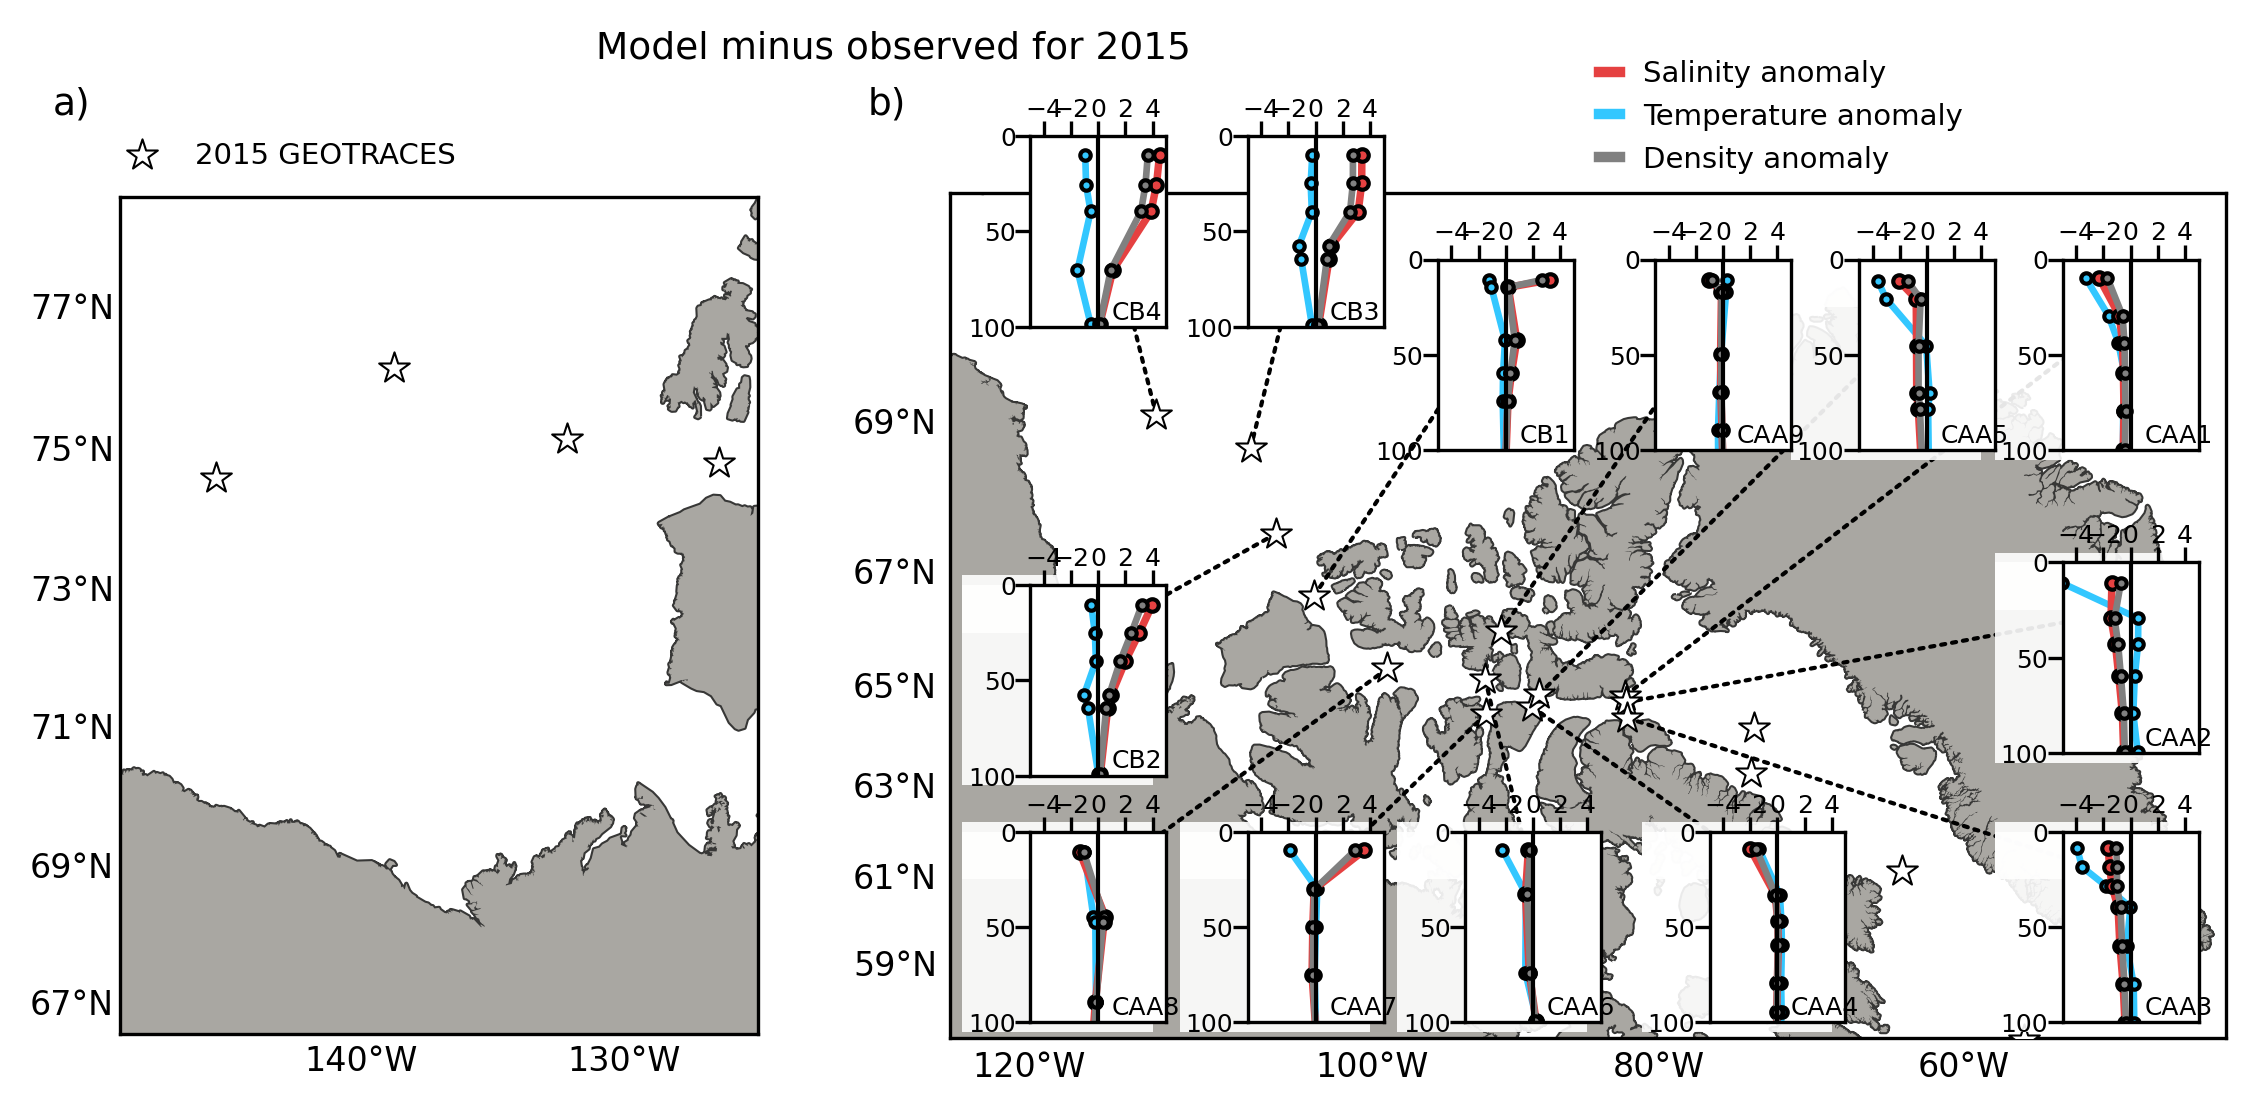

In [40]:
full_figure_anomaly(ln_full=False, title='Model minus observed for 2015')

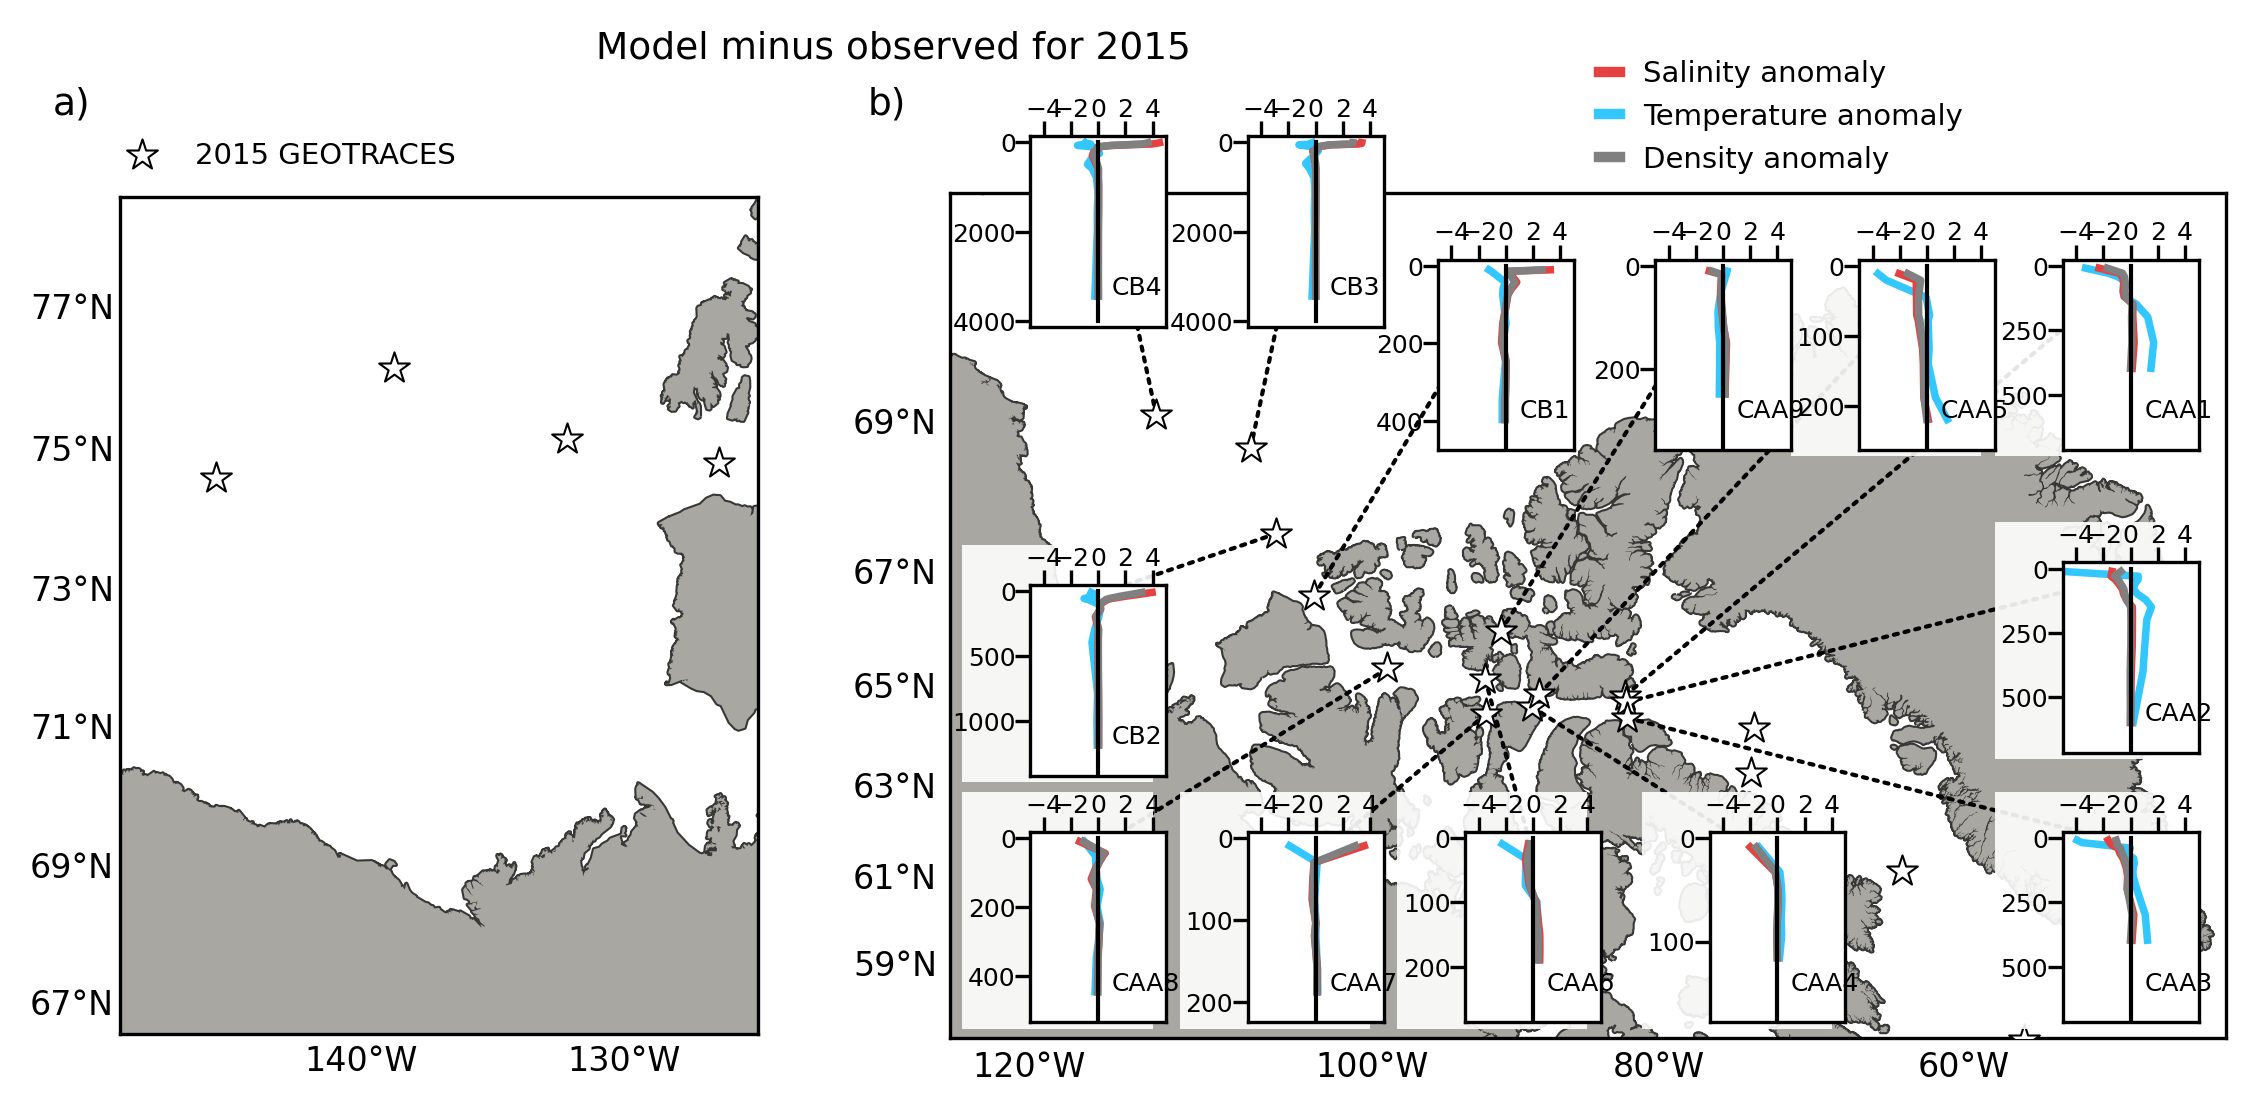

In [41]:
full_figure_anomaly(ln_full=True, title='Model minus observed for 2015')

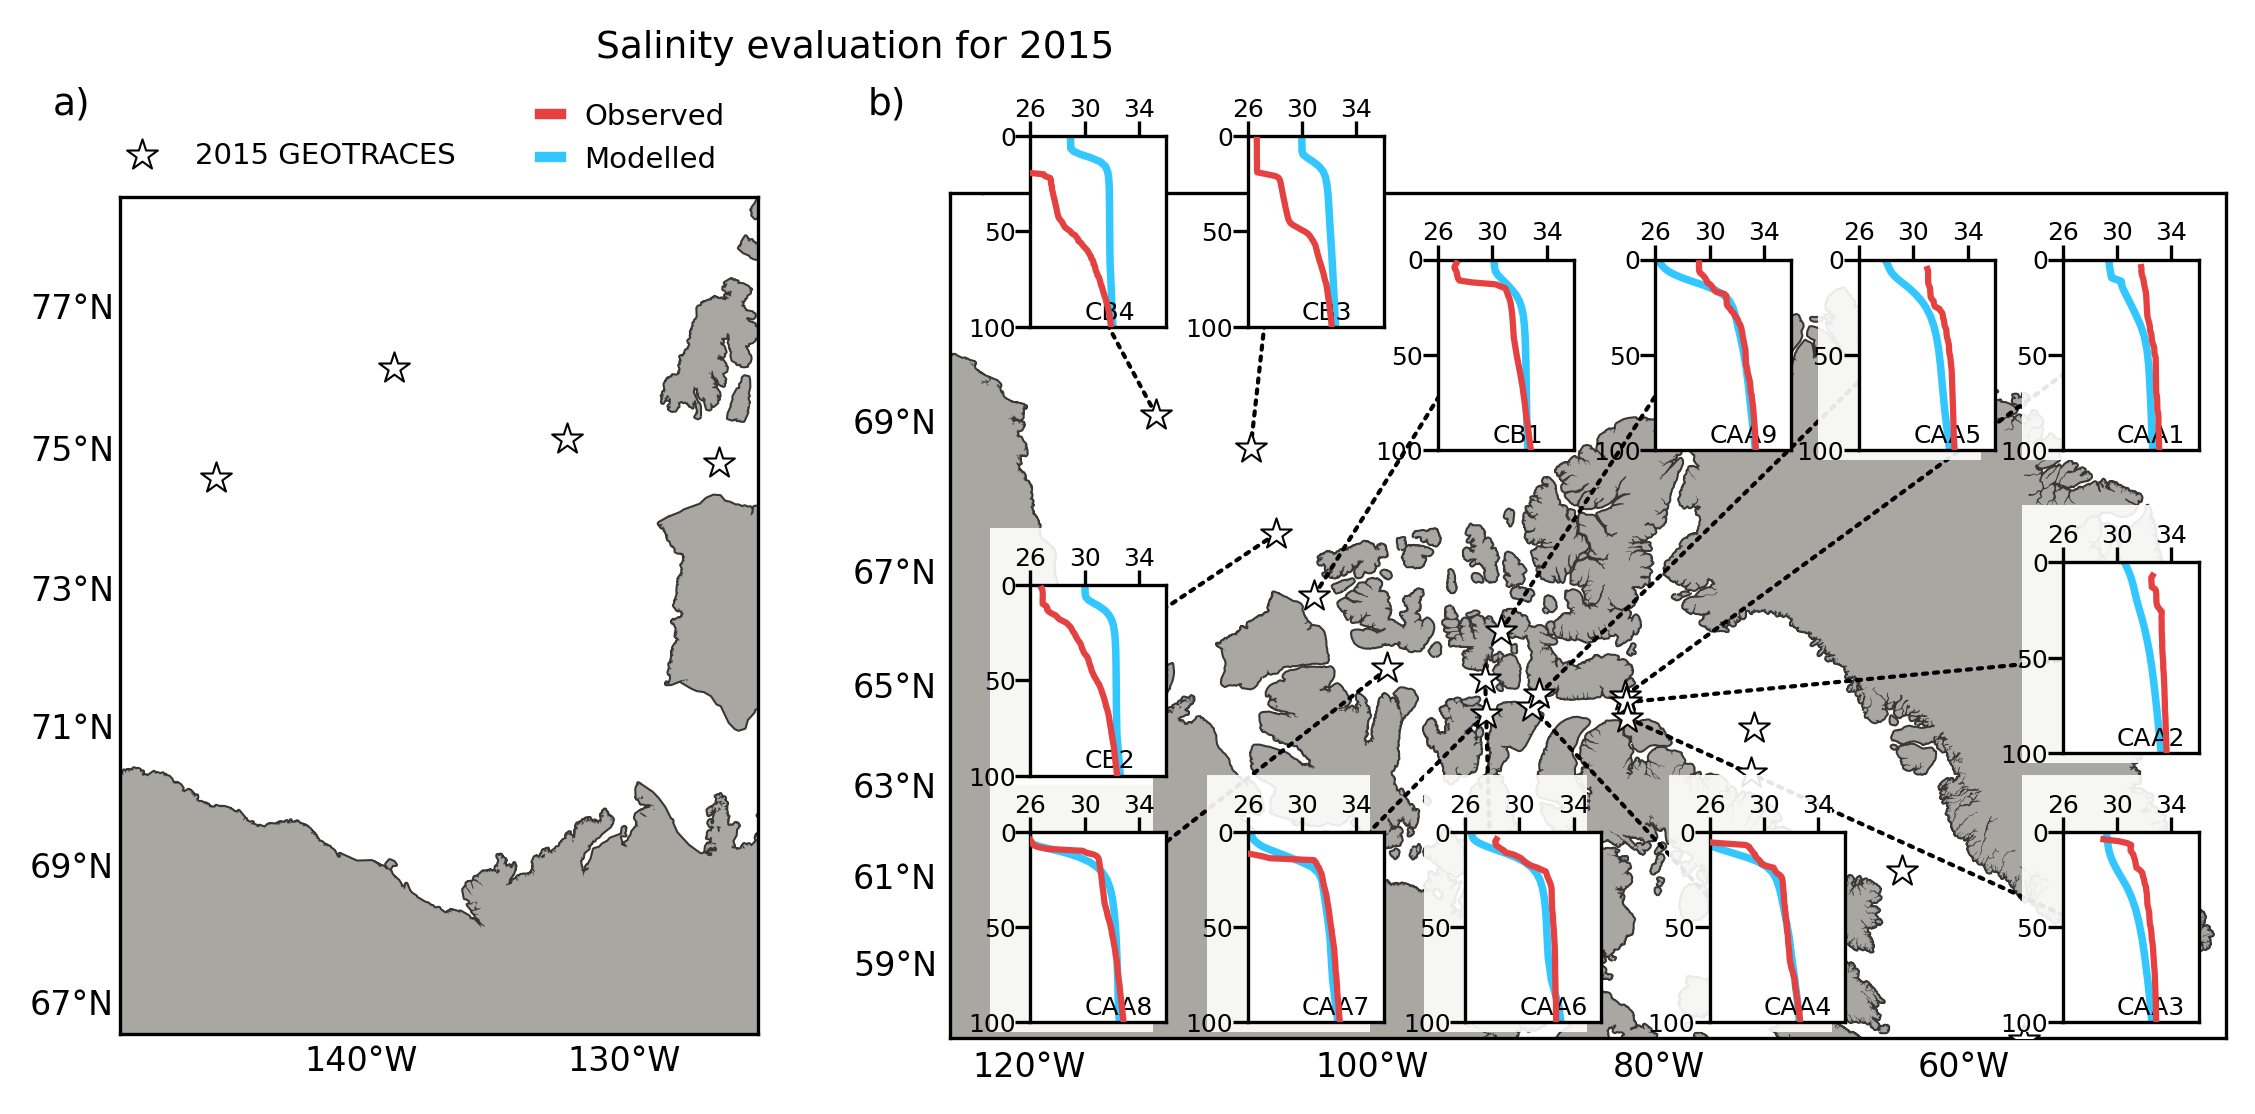

In [96]:
full_figure(ln_full=False, title='Salinity evaluation for 2015', profile_type='sal')

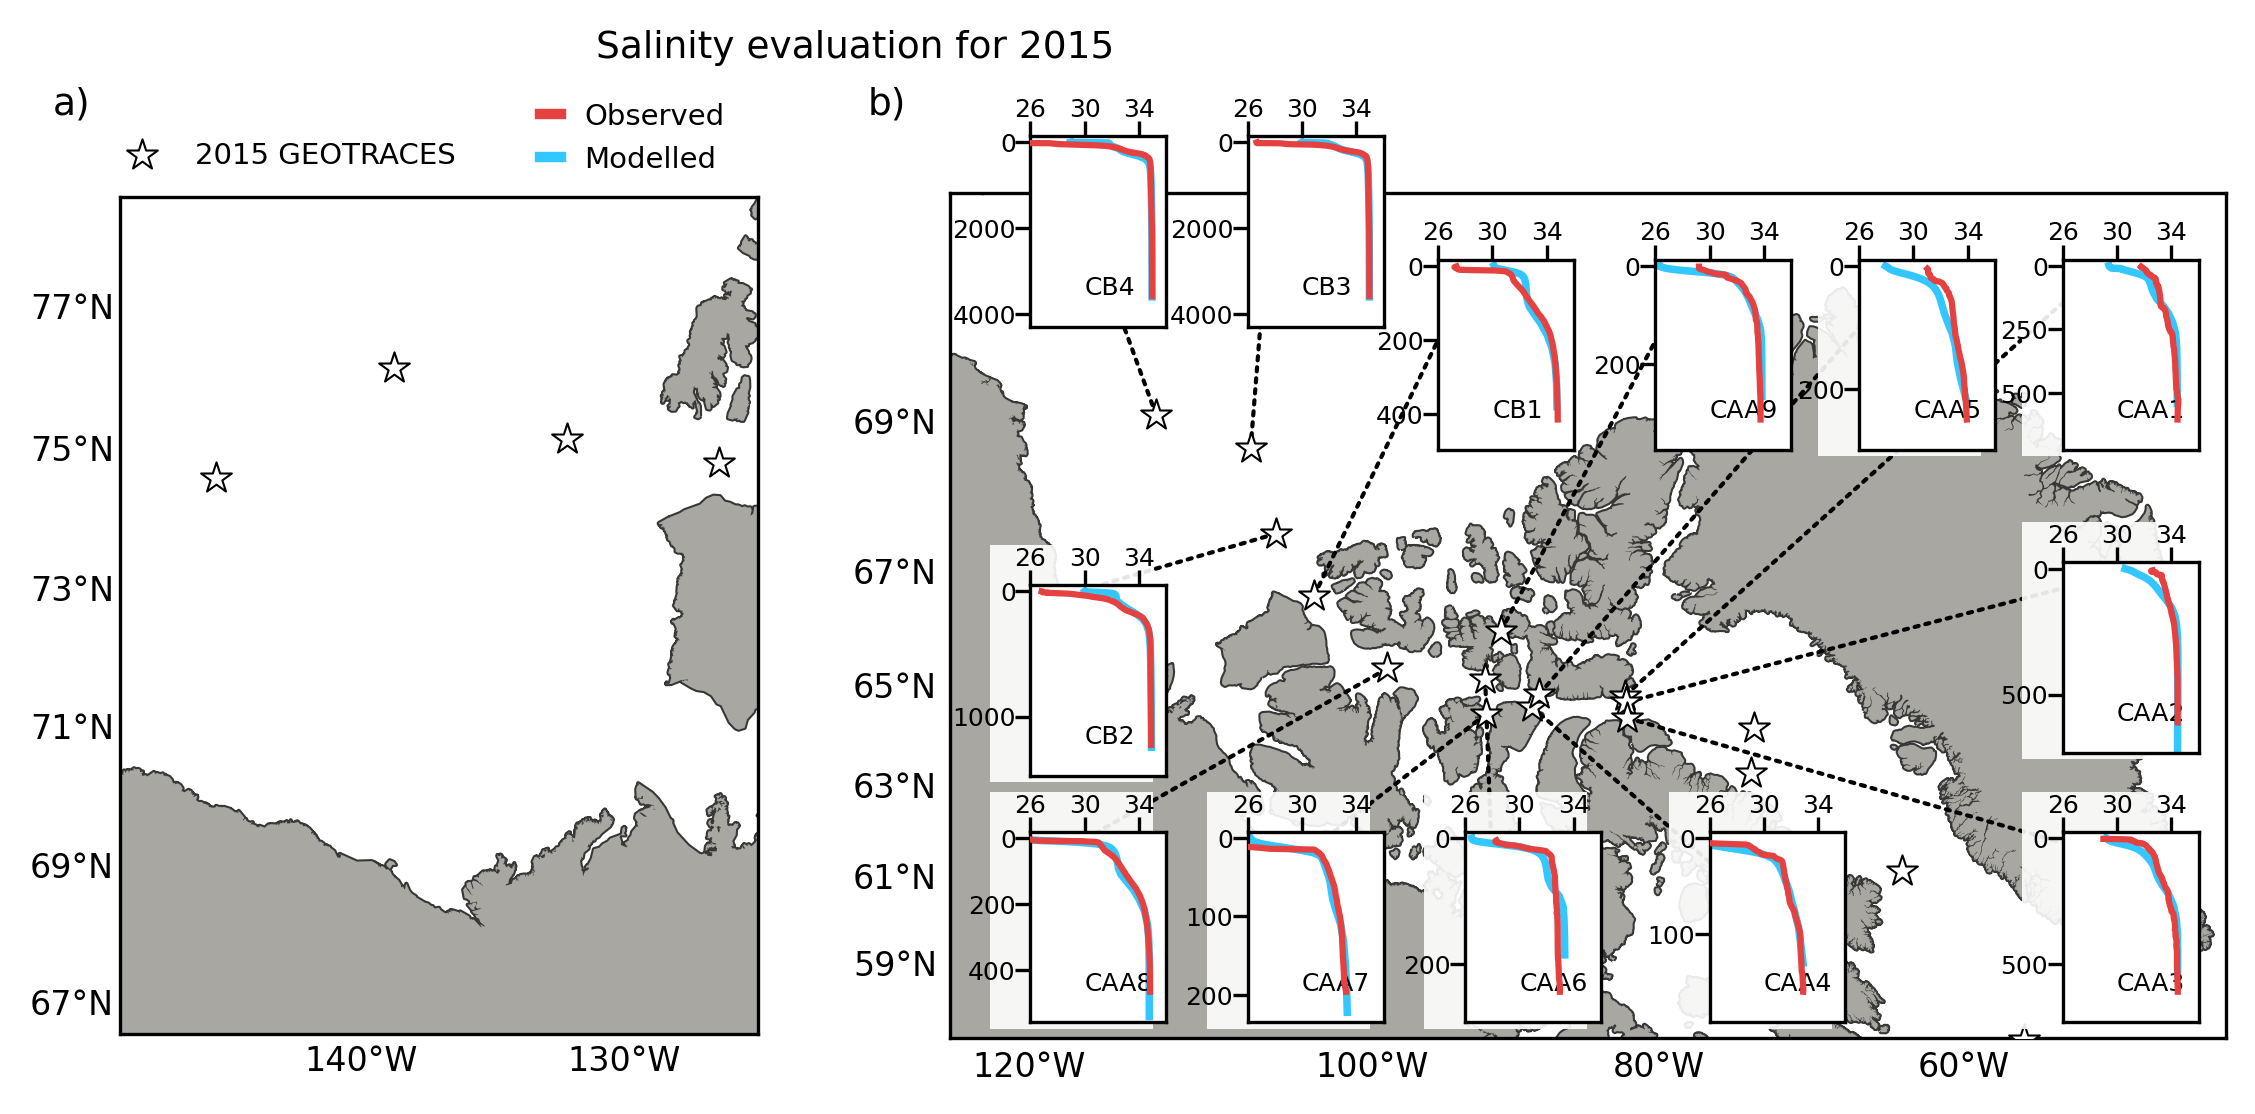

In [29]:
full_figure(ln_full=True, title='Salinity evaluation for 2015', profile_type='sal')

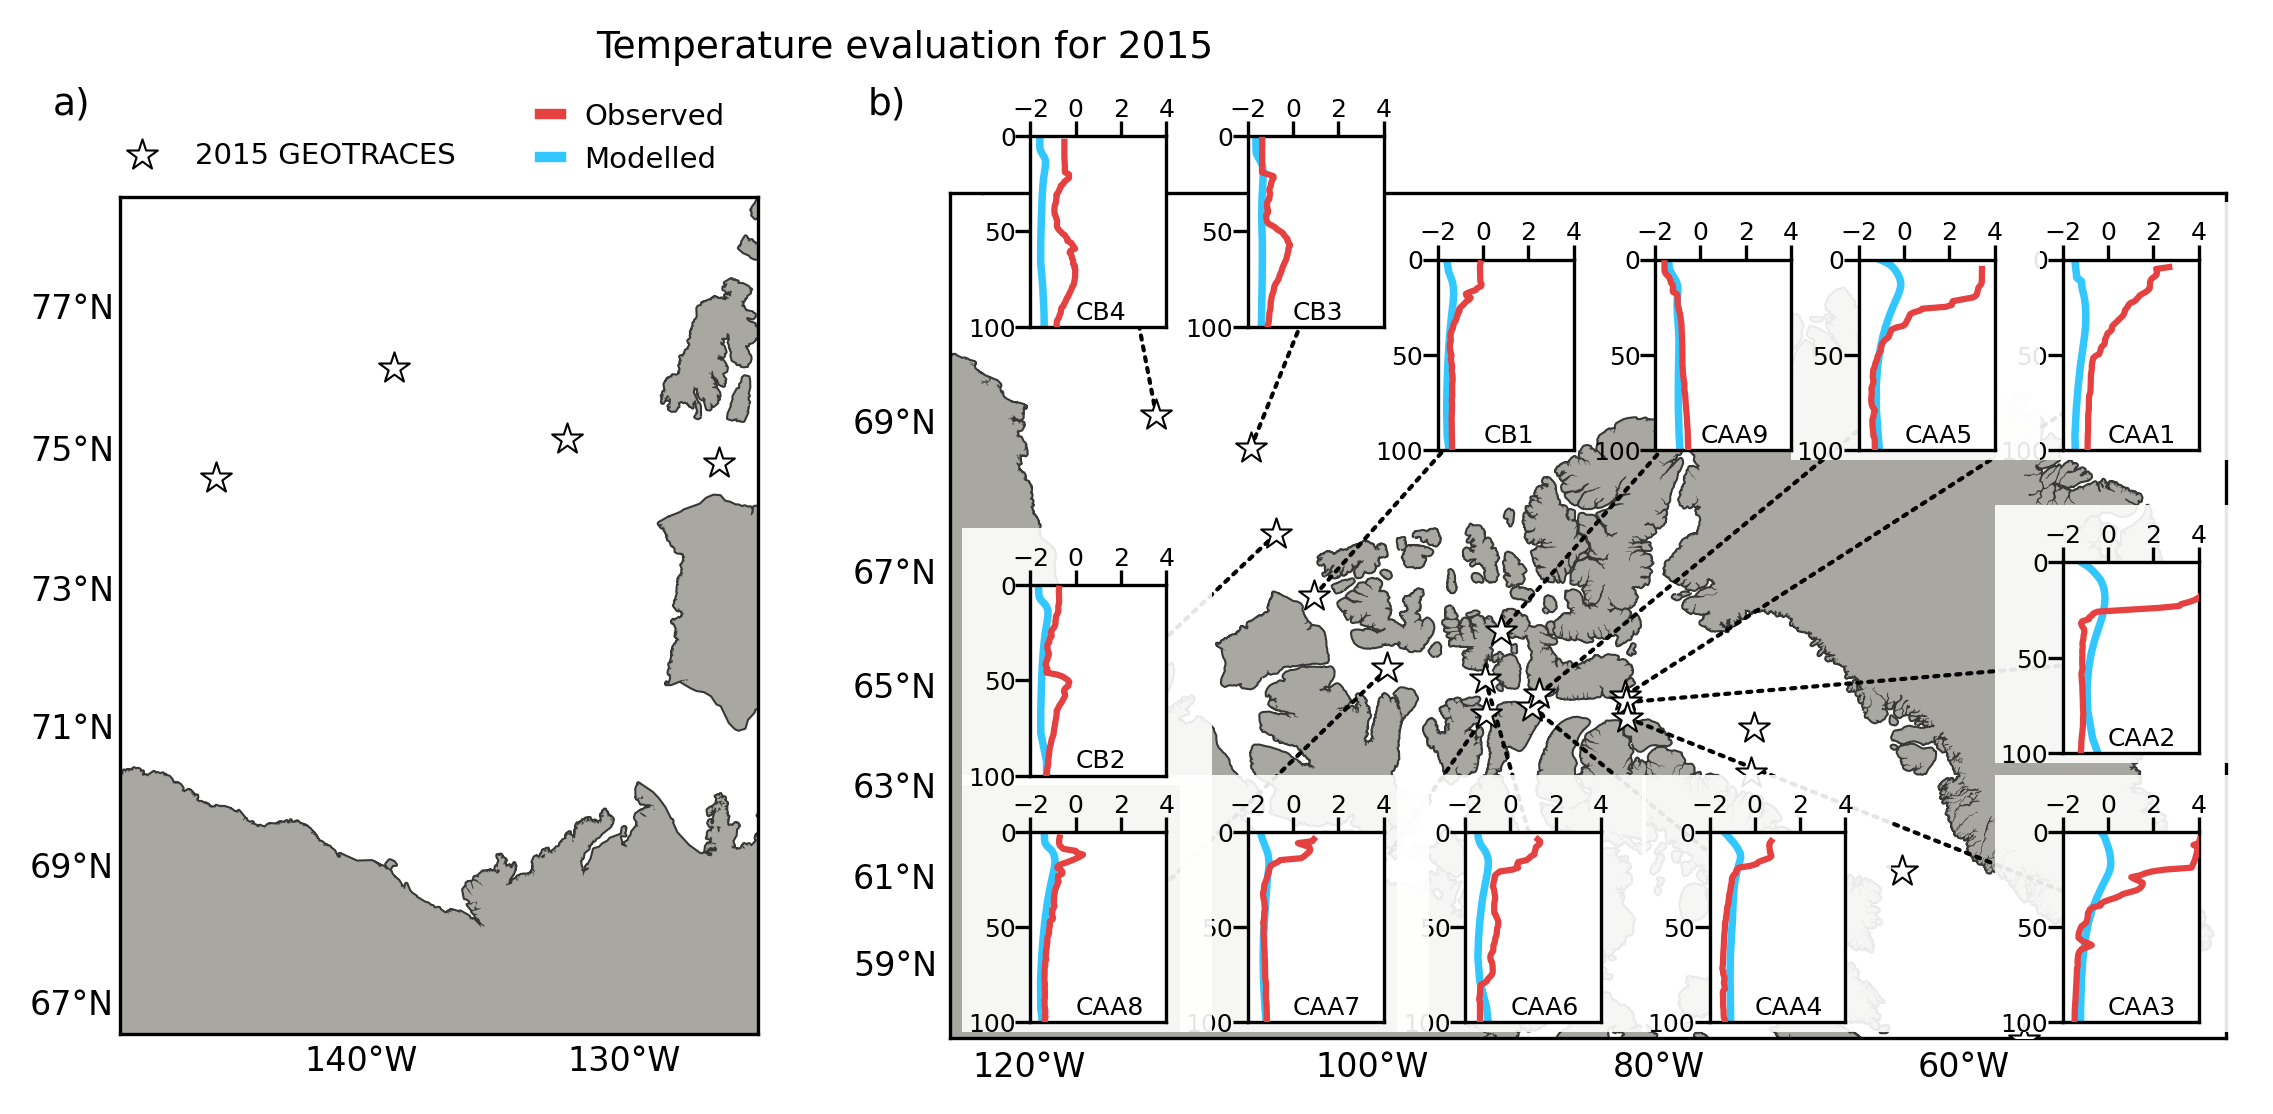

In [30]:
full_figure(ln_full=False, title='Temperature evaluation for 2015', profile_type='temp')

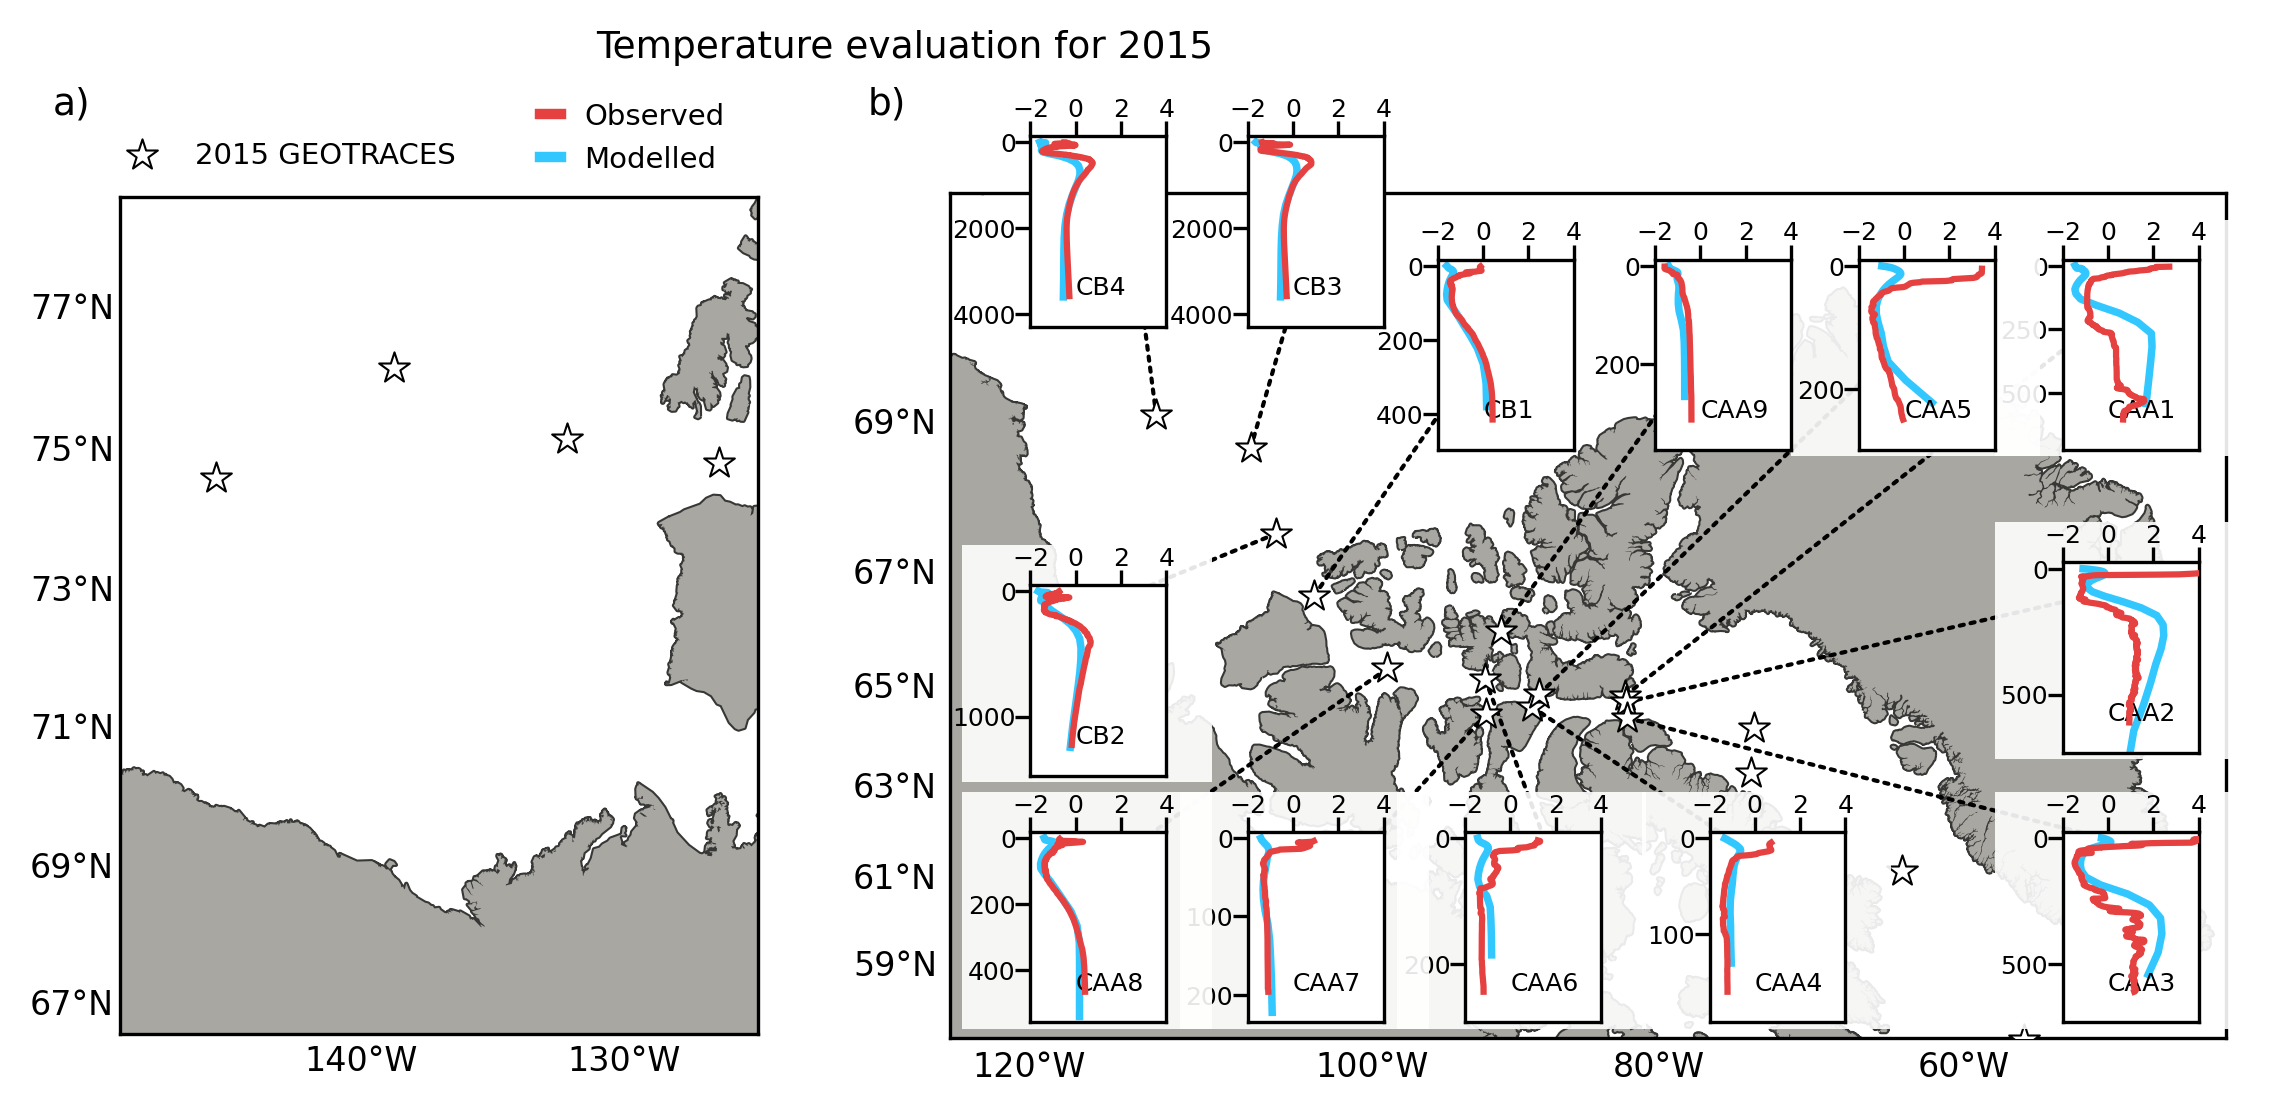

In [31]:
full_figure(ln_full=True, title='Temperature evaluation for 2015', profile_type='temp')

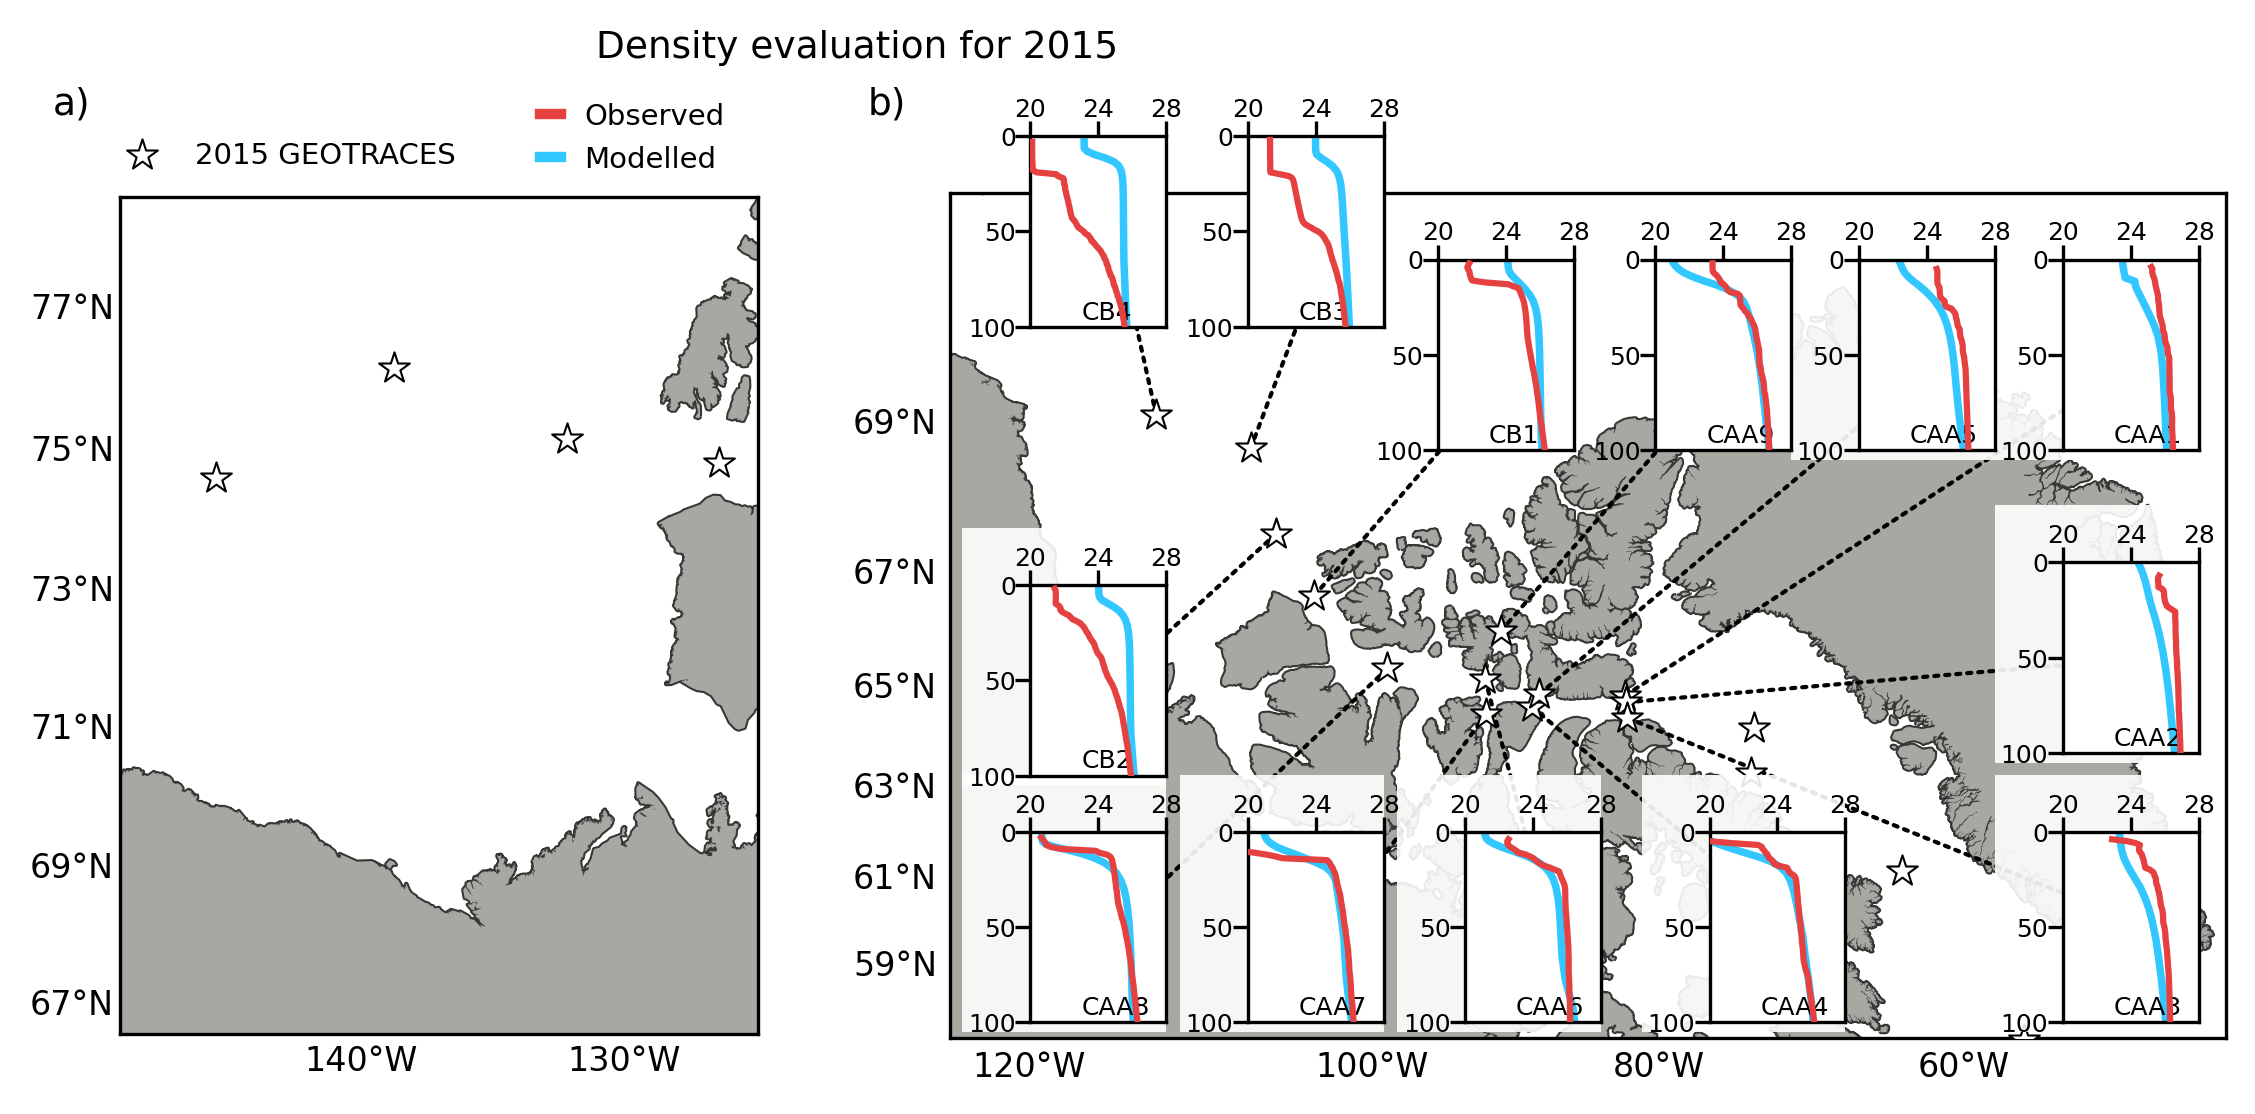

In [32]:
full_figure(ln_full=False, title='Density evaluation for 2015', profile_type='density')

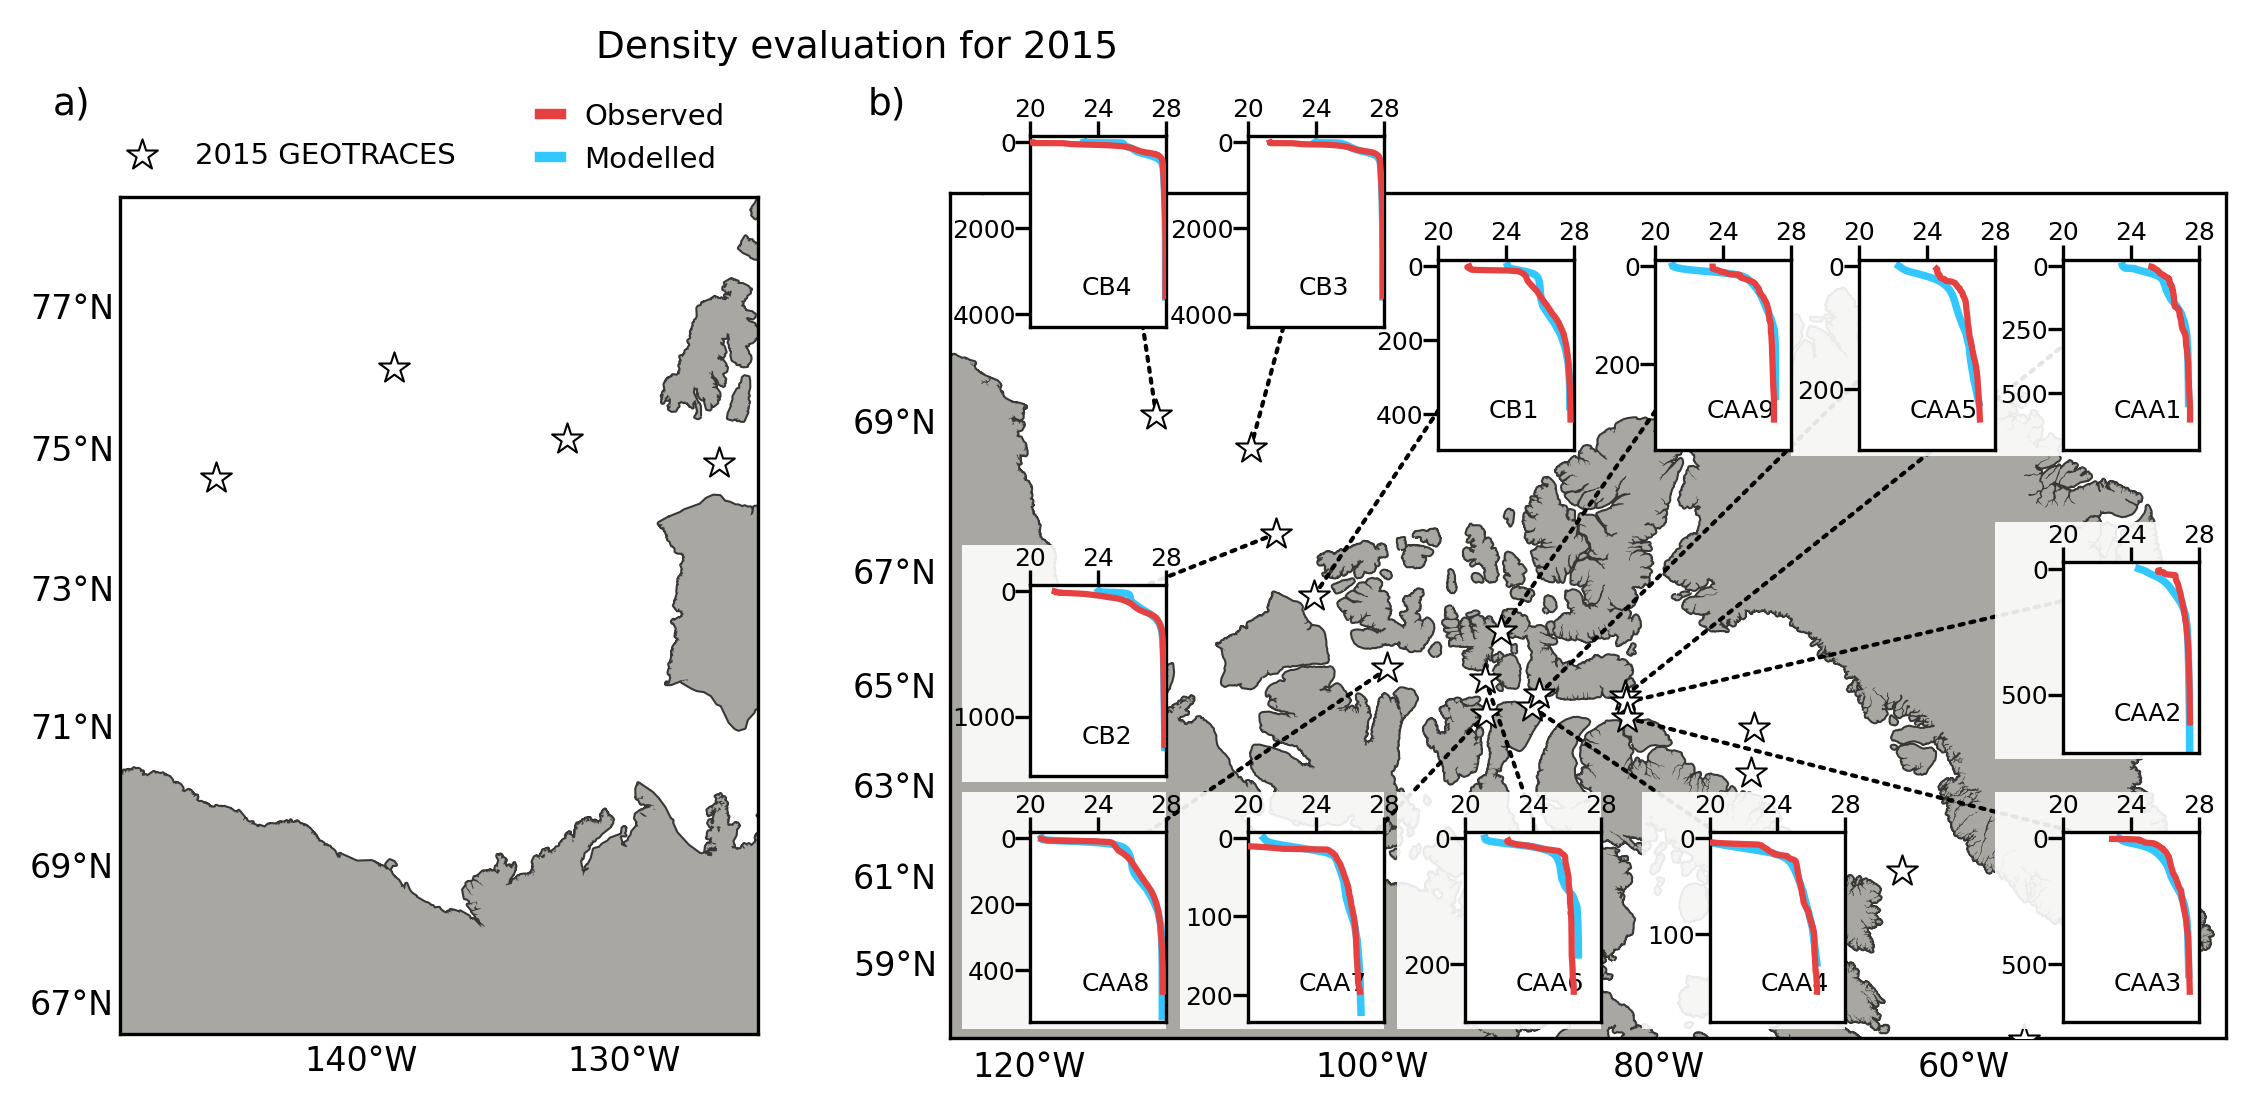

In [33]:
full_figure(ln_full=True, title='Density evaluation for 2015', profile_type='density')